# Transforming Images via Wasserstein Distance

This guide demonstrates how to compute a **path of transformation** between two images using the **Wasserstein (Earth Mover’s) Distance**, leveraging concepts from **optimal transport**.


## Overview

We treat two images as **probability distributions** over pixels and use **optimal transport theory** to compute a plan that describes how mass (pixel intensity) should move to morph one image into another. Interpolating this plan produces intermediate images representing the transformation path.

## Requirements

* `numpy`
* `scikit-image`
* `POT` (Python Optimal Transport)
* `matplotlib`

In [1]:
!pip install numpy scikit-image POT matplotlib

  Using cached numpy-2.3.1-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached matplotlib-3.10.3-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached pillow-11.3.0-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached contourpy-1.3.2-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached numpy-2.3.1-cp313-cp313-win_amd64.whl (12.7 MB)
   ---------------------------------------- 

## 📚 References

* [POT Library](https://pythonot.github.io/)
* Peyré, G., Cuturi, M. (2019). *Computational Optimal Transport*
* Villani, C. (2008). *Optimal Transport: Old and New*

## Steps

| Step | Description                                                    |
| ---- | -------------------------------------------------------------- |
| 1    | Normalise input images as 2D probability distributions         |
| 2    | Compute cost matrix and transport plan using EMD               |
| 3    | Interpolate using transport vectors or Wasserstein barycenters |
| 4    | Visualize each interpolated step for animation or analysis     |

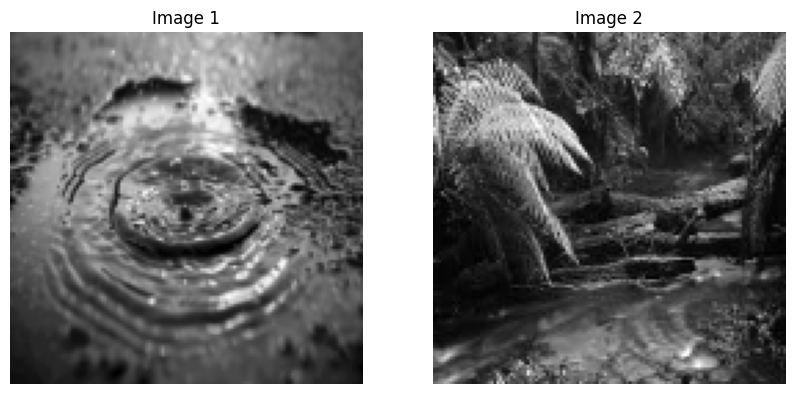

d:\mukul\Documents\Obsidian Vault\git_obsidian\ML\Optimal Transport\wasserstein_projection\.venv\Lib\site-packages\ot\lp\__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


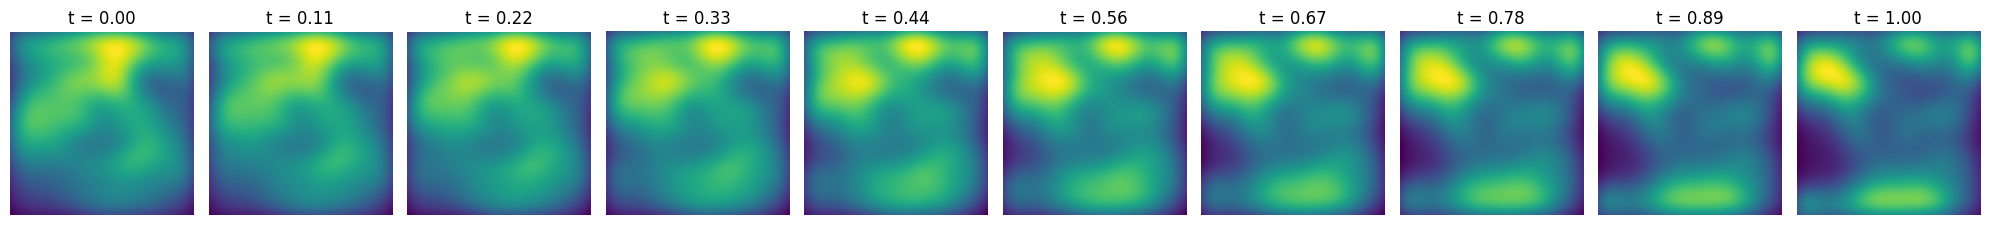

In [21]:
# Wasserstein Image Morphing using Optimal Transport

# Imports
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
import ot

# Step 1: Preprocess Images
def normalize_image(image_path, size=(64, 64)):
    image = imread(image_path)
    image = resize(image, size, anti_aliasing=True)
    gray = rgb2gray(image)
    normalized = gray / np.sum(gray)
    return normalized

# Load and normalize two images
im1 = normalize_image('image1.jpg', size=(128, 128))
im2 = normalize_image('image2.jpg', size=(128, 128))

# Visualize the images side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(im1, cmap='gray')
plt.title('Image 1')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(im2, cmap='gray')
plt.title('Image 2')
plt.axis('off')
plt.show()

# Step 2: Compute Optimal Transport Plan

# Flatten images into 1D distributions
a = im1.ravel()
b = im2.ravel()

# Create cost matrix: Euclidean distances between pixels
n = im1.shape[0]
x, y = np.meshgrid(np.arange(n), np.arange(n))
positions = np.vstack((x.ravel(), y.ravel())).T
M = ot.dist(positions, positions)

# Compute optimal transport plan using EMD
P = ot.emd(a, b, M)

# Step 3: Interpolation via Entropic Barycenter
# (for smoother results)
def interpolate_barycenter(im1, im2, t, reg=1e-2):
    return ot.bregman.convolutional_barycenter2d([im1, im2], 
                                                 reg=reg, 
                                                 weights=np.array([1 - t, t]), numItermax=int(1e6))

# Step 4: Generate and Display Interpolated Images
timesteps = np.linspace(0, 1, 10)

fig, axes = plt.subplots(1, len(timesteps), figsize=(20, 3))
for i, t in enumerate(timesteps):
    bary = interpolate_barycenter(im1, im2, t)
    axes[i].imshow(bary)
    axes[i].set_title(f't = {t:.2f}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


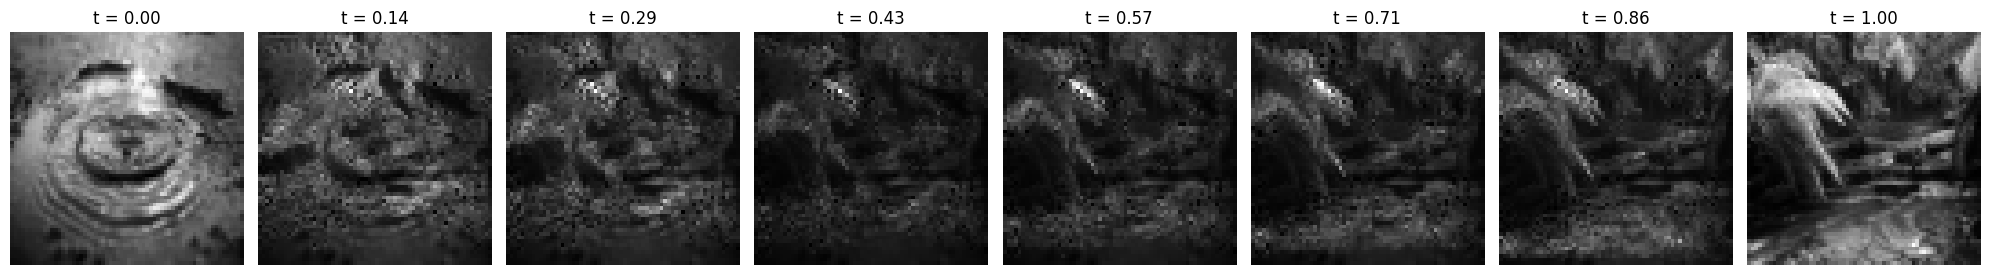

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
import ot

# Step 1: Preprocess Images
def normalize_image(image_path, size=(64, 64)):
    image = imread(image_path)
    image = resize(image, size, anti_aliasing=True)
    gray = rgb2gray(image)
    normalized = gray / np.sum(gray)  # Normalize to sum = 1
    return normalized

# Load and normalize two images
im1 = normalize_image('image1.jpg', size=(64, 64))
im2 = normalize_image('image2.jpg', size=(64, 64))

# Flatten images
a = im1.ravel()
b = im2.ravel()
assert np.isclose(np.sum(a), 1), "a must sum to 1"
assert np.isclose(np.sum(b), 1), "b must sum to 1"

# Step 2: Create position grid for cost matrix
h, w = im1.shape
x, y = np.meshgrid(np.arange(w), np.arange(h))  # Note: width, then height
positions = np.stack([x.ravel(), y.ravel()], axis=1)  # shape (H*W, 2)

# Step 3: Compute pairwise cost matrix
M = ot.dist(positions, positions, metric='euclidean')  # shape (N, N)
M /= M.max()  # Optional: normalize costs to [0, 1]

# Step 4: Compute Optimal Transport Plan using EMD
P = ot.emd(a, b, M)  # shape (N, N)

# Step 5: Displacement interpolation
def displacement_interpolation(P, positions, t, shape):
    h, w = shape
    interpolated = np.zeros((h, w))

    for i in range(positions.shape[0]):
        for j in range(positions.shape[0]):
            mass = P[i, j]
            if mass == 0:
                continue

            # Compute interpolated position
            interp_pos = (1 - t) * positions[i] + t * positions[j]
            x, y = interp_pos

            # Get integer coordinates
            x0, y0 = int(np.floor(x)), int(np.floor(y))
            x1, y1 = x0 + 1, y0 + 1

            # Compute barycentric weights
            wx1 = x - x0
            wx0 = 1 - wx1
            wy1 = y - y0
            wy0 = 1 - wy1

            # Distribute mass to the 4 surrounding pixels
            for dx, wx in zip([0, 1], [wx0, wx1]):
                for dy, wy in zip([0, 1], [wy0, wy1]):
                    xi = x0 + dx
                    yi = y0 + dy
                    if 0 <= xi < w and 0 <= yi < h:
                        interpolated[yi, xi] += mass * wx * wy

    return interpolated


# Step 6: Generate morphing sequence
timesteps = np.linspace(0, 1, 8)
fig, axes = plt.subplots(1, len(timesteps), figsize=(20, 3))

for i, t in enumerate(timesteps):
    img = displacement_interpolation(P, positions, t, im1.shape)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f't = {t:.2f}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## coloured image animation

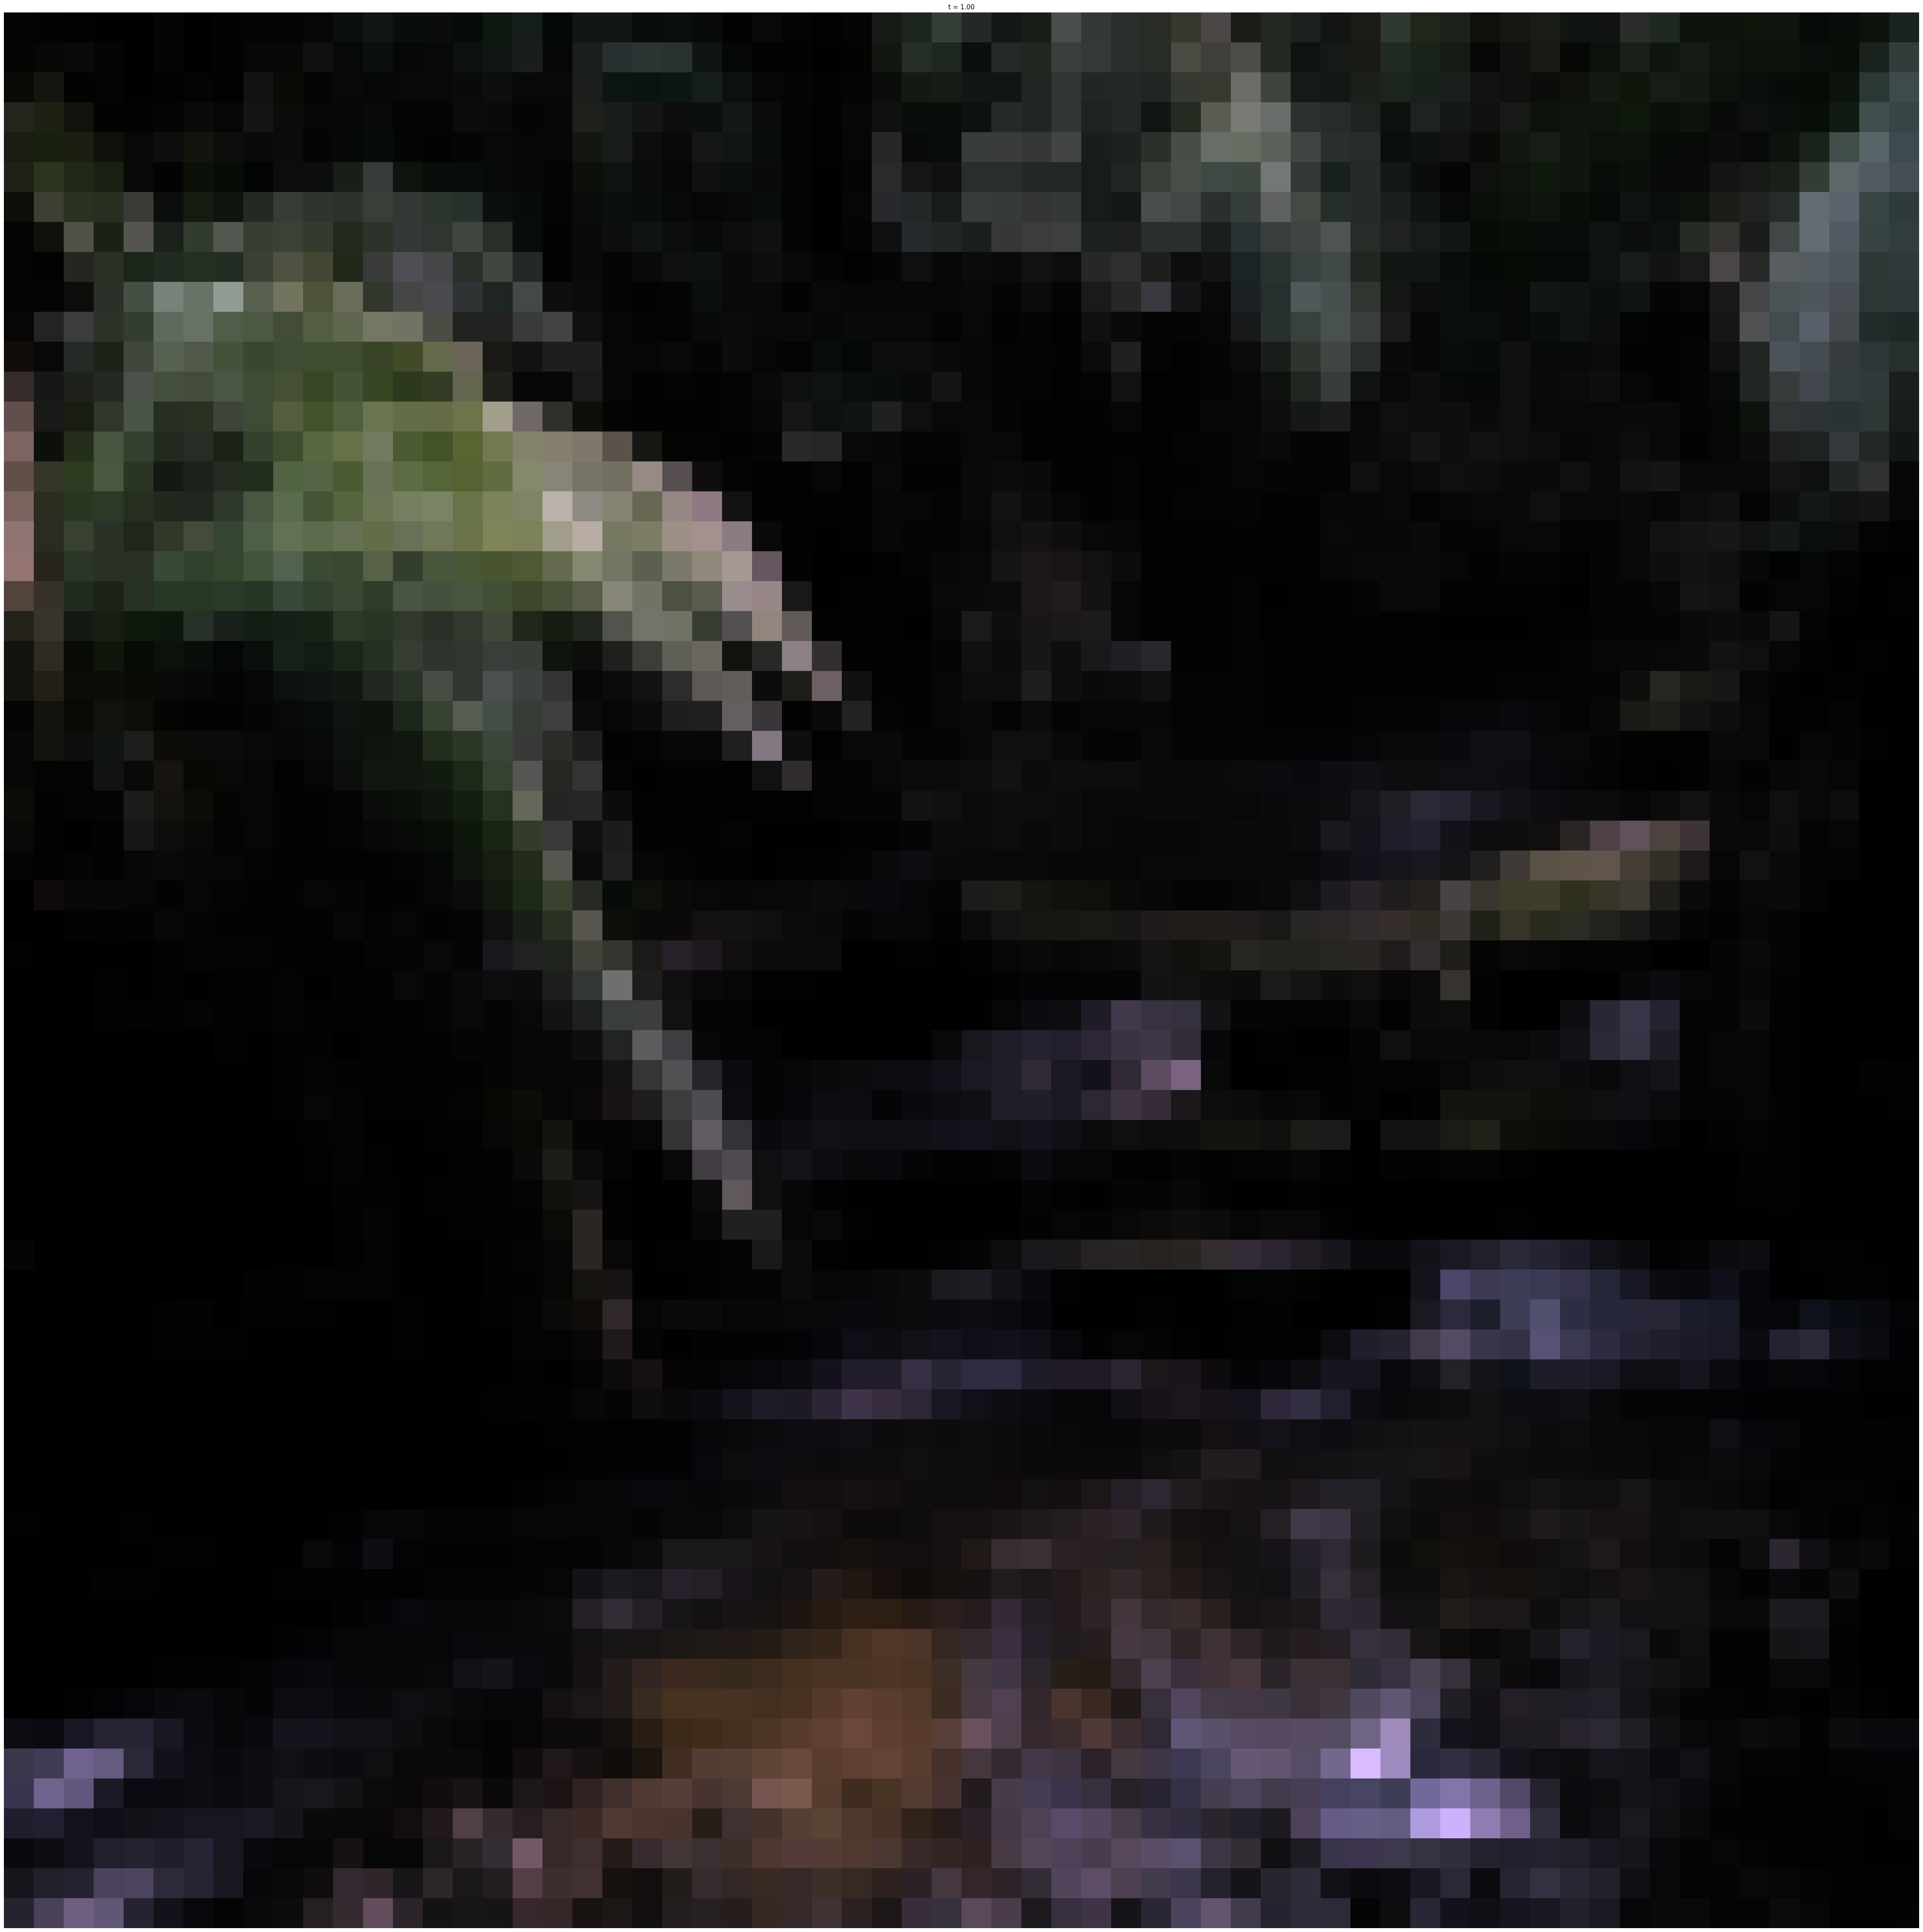

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import ot
import matplotlib.animation as animation

# Normalize and load RGB image
def normalize_image_rgb(image_path, size=(64, 64)):
    image = imread(image_path)
    image = resize(image, size, anti_aliasing=True)
    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)
    if image.shape[-1] == 4:
        image = image[..., :3]
    norm_channels = []
    for c in range(3):
        channel = image[..., c]
        channel = channel / np.sum(channel)
        norm_channels.append(channel)
    return np.stack(norm_channels, axis=-1)

im1 = normalize_image_rgb('image1.jpg', size=(64, 64))
im2 = normalize_image_rgb('image2.jpg', size=(64, 64))

h, w, _ = im1.shape
positions = np.stack(np.meshgrid(np.arange(w), np.arange(h)), axis=-1).reshape(-1, 2)

gray1 = np.mean(im1, axis=2)
gray2 = np.mean(im2, axis=2)
a = gray1.ravel() / np.sum(gray1)
b = gray2.ravel() / np.sum(gray2)

M = ot.dist(positions, positions).astype(np.float64)
M /= M.max()
P = ot.emd(a, b, M, numItermax=int(1e8))

def displacement_interpolation_rgb(P, positions, t, shape, im1, im2):
    h, w = shape
    interpolated = np.zeros((h, w, 3))

    for c in range(3):
        channel1 = im1[..., c].ravel()
        channel2 = im2[..., c].ravel()
        for i in range(positions.shape[0]):
            for j in range(positions.shape[0]):
                mass = P[i, j]
                if mass == 0:
                    continue
                value = (1 - t) * channel1[i] + t * channel2[j]
                interp_pos = (1 - t) * positions[i] + t * positions[j]
                x, y = interp_pos
                x0, y0 = int(np.floor(x)), int(np.floor(y))
                x1, y1 = x0 + 1, y0 + 1
                wx1, wx0 = x - x0, 1 - (x - x0)
                wy1, wy0 = y - y0, 1 - (y - y0)
                for dx, wx in zip([0, 1], [wx0, wx1]):
                    for dy, wy in zip([0, 1], [wy0, wy1]):
                        xi, yi = x0 + dx, y0 + dy
                        if 0 <= xi < w and 0 <= yi < h:
                            interpolated[yi, xi, c] += mass * value * wx * wy
    return interpolated

# Create figure and axis
fig, ax = plt.subplots(figsize=(64, 64))
im = ax.imshow(np.zeros((h, w, 3)), interpolation='nearest')
ax.axis('off')

# Update function for animation
def update(frame):
    t = frame / (num_frames - 1)
    img = displacement_interpolation_rgb(P, positions, t, (h, w), im1, im2)
    img /= img.max()  # normalize for display
    im.set_array(img)
    ax.set_title(f't = {t:.2f}')
    return [im]

# Number of frames in the animation
num_frames = 30

# Create animation
ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=True)

# To save animation as mp4 (requires ffmpeg installed)
ani.save('wasserstein_morph.mp4',fps=10)

# Or save as gif (requires imagemagick)
# ani.save('wasserstein_morph.gif', writer='imagemagick', fps=10)

# plt.show()
